In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import pearsonr

# Simulate longitudinal data (50/200/500 individuals and 10% receive treatment that result in oral bacterial enrichment)

In [3]:
mu_x = -3 # log10(oral bacterial fraction)
mu_y = 8  # log10(total bacterial load)
sigma_array = [0,0.025,0.05,0.1,0.25,0.5,1.0] # standard deviation
n_ind = 200 # total number of individuals
n_samples_per_ind = 5 # number of samples per individual
p_perturbed = 0.1 # number of individuals that have been perturbed
mc_runs = 10

res = []
for k in np.arange(mc_runs):
    for sigma in sigma_array:
        cov = np.array([[sigma, 0], [0, sigma]]) # covariance matrix
        baselines = np.random.multivariate_normal([mu_x, mu_y], cov, size=n_ind) # generate baseline for individuals
        df_baselines = pd.DataFrame(baselines, columns=['mu_x','mu_y'])
        df_baselines.loc[df_baselines.mu_x>0, 'mu_x'] = 0

        # generate time series for each individual
        for i in np.arange(n_ind):
            ctr_x = df_baselines.iloc[i,0]
            ctr_y = df_baselines.iloc[i,1]
            res.append([sigma, k, i, ctr_x, ctr_y, 'marker'])
            res.append([sigma, k, i, ctr_x, ctr_y, 'expansion'])

            # determine if the individual received perturbations
            m = random.uniform(0, 1)
            if m <= p_perturbed:
                # perturbed, randomly sample oral fraction between mu_x and 0
                perturbed_x = np.random.uniform(low=ctr_x, high=0, size=n_samples_per_ind-1)
                
                # marker hypothesis
                df_perturbed_data = pd.DataFrame(perturbed_x, columns=['Perturbed_x'])
                df_perturbed_data['new_mu_y'] = ctr_y-(df_perturbed_data['Perturbed_x']-ctr_x)
                df_perturbed_data['new_sigma_y'] = sigma * df_perturbed_data['new_mu_y']/ctr_y
                df_perturbed_data['Perturbed_y'] = np.random.normal(df_perturbed_data['new_mu_y'], df_perturbed_data['new_sigma_y'])
                for px, py in zip(df_perturbed_data.Perturbed_x, df_perturbed_data.Perturbed_y):
                    res.append([sigma, k, i, px, py, 'marker'])
                    
                # expansion hypothesis
                gut_load = (1-10**ctr_x) * (10**ctr_y)
                df_perturbed_data['new_mu_y'] = np.log10(gut_load/(1-10**df_perturbed_data['Perturbed_x']))
                df_perturbed_data['new_sigma_y'] = sigma * df_perturbed_data['new_mu_y']/ctr_y
                df_perturbed_data['Perturbed_y'] = np.random.normal(df_perturbed_data['new_mu_y'], df_perturbed_data['new_sigma_y'])
                for px, py in zip(df_perturbed_data.Perturbed_x, df_perturbed_data.Perturbed_y):
                    res.append([sigma, k, i, px, py, 'expansion'])
            else:
                # no perturbation, generate n_samples_per_ind-1 baselines
                additional_baselines = np.random.multivariate_normal([ctr_x, ctr_y], cov, size=n_samples_per_ind-1)
                df_additional_baselines = pd.DataFrame(additional_baselines, columns=['mu_x','mu_y'])
                df_additional_baselines.loc[df_additional_baselines.mu_x>0, 'mu_x'] = 0
                for additional_x, additional_y in zip(df_additional_baselines.mu_x, df_additional_baselines.mu_y):
                    res.append([sigma, k, i, additional_x, additional_y, 'marker'])
                    res.append([sigma, k, i, additional_x, additional_y, 'expansion'])
df_res = pd.DataFrame(res, columns=['Sigma','MC','Individual','X','Y','Hypothesis'])
df_res.to_csv("simulated_longitudinal_data_%d.csv"%(n_ind), index=False)
df_res.head()

,Sigma,MC,Individual,X,Y,Hypothesis
0,0.0,0,0,-3.0,8.0,marker
1,0.0,0,0,-3.0,8.0,expansion
2,0.0,0,0,-3.0,8.0,marker
3,0.0,0,0,-3.0,8.0,expansion
4,0.0,0,0,-3.0,8.0,marker


# Simulate case-control data (100 healthy controls and 100 patients. all patient receive treatment that may lead to oral bacterial enrichment)

In [89]:
mu_x = -3 # log10(oral bacterial fraction)
mu_y = 8  # log10(total bacterial load)
sigma_array = [0,0.025,0.05,0.1,0.25,0.5,1.0] # standard deviation
n_ind = 200 # total number of individuals
p_perturbed = 0.1# number of individuals that have been perturbed
mc_runs = 10

res = []
for k in np.arange(mc_runs):
    for sigma in sigma_array:
        cov = np.array([[sigma, 0], [0, sigma]]) # covariance matrix
        
        # create baseline samples for healthy controls
        baselines_hc = np.random.multivariate_normal([mu_x, mu_y], cov, size=int(1.2*n_ind/2)) # generate baseline for individuals
        df_baselines_hc = pd.DataFrame(baselines_hc, columns=['mu_x','mu_y'])
        df_baselines_hc = df_baselines_hc[(df_baselines_hc.mu_x<0) & (df_baselines_hc.mu_y>0)]
        df_baselines_hc = df_baselines_hc.iloc[0:int(n_ind/2), :]
        
        # create baseline samples for patients
        baselines_pa = np.random.multivariate_normal([mu_x, mu_y], cov, size=int(1.2*n_ind/2)) # generate baseline for individuals
        df_baselines_pa = pd.DataFrame(baselines_pa, columns=['mu_x','mu_y'])
        df_baselines_pa = df_baselines_pa[(df_baselines_pa.mu_x<0) & (df_baselines_pa.mu_y>0)]
        df_baselines_pa = df_baselines_pa.iloc[0:int(n_ind/2), :]

        # generate perturbed sample for patients
        for i in np.arange(int(n_ind/2)):
            # add data for HC
            ctr_x = df_baselines_hc.iloc[i,0]
            ctr_y = df_baselines_hc.iloc[i,1]
            res.append([sigma, k, i, ctr_x, ctr_y, 'marker'])
            res.append([sigma, k, i, ctr_x, ctr_y, 'expansion'])

            # add data for patient
            ctr_x = df_baselines_pa.iloc[i,0]
            ctr_y = df_baselines_pa.iloc[i,1]
            
            # determine if the individual received perturbations
            m = random.uniform(0, 1)
            if m <= p_perturbed:
                # perturbed, randomly sample oral fraction between mu_x and 0
                perturbed_x = np.random.uniform(low=ctr_x, high=0, size=2)
                
                # marker hypothesis
                df_perturbed_data = pd.DataFrame(perturbed_x, columns=['Perturbed_x'])
                df_perturbed_data['new_mu_y'] = ctr_y-(df_perturbed_data['Perturbed_x']-ctr_x)
                df_perturbed_data['new_sigma_y'] = sigma * df_perturbed_data['new_mu_y']/ctr_y
                df_perturbed_data['Perturbed_y'] = np.random.normal(df_perturbed_data['new_mu_y'], df_perturbed_data['new_sigma_y'])
                df_perturbed_data = df_perturbed_data[(df_perturbed_data.Perturbed_x<0) & (df_perturbed_data.Perturbed_y>0)]
                res.append([sigma, k, i, df_perturbed_data.iloc[0,:].Perturbed_x, df_perturbed_data.iloc[0,:].Perturbed_y, 'marker'])
                    
                # expansion hypothesis
                gut_load = (1-10**ctr_x) * (10**ctr_y)
                df_perturbed_data['new_mu_y'] = np.log10(gut_load/(1-10**df_perturbed_data['Perturbed_x']))
                df_perturbed_data['new_sigma_y'] = sigma * df_perturbed_data['new_mu_y']/ctr_y
                df_perturbed_data['Perturbed_y'] = np.random.normal(df_perturbed_data['new_mu_y'], df_perturbed_data['new_sigma_y'])
                df_perturbed_data = df_perturbed_data[(df_perturbed_data.Perturbed_x<0) & (df_perturbed_data.Perturbed_y>0)]
                res.append([sigma, k, i, df_perturbed_data.iloc[0,:].Perturbed_x, df_perturbed_data.iloc[0,:].Perturbed_y, 'expansion'])
            else:
                # no perturbation, generate another baseline
                additional_baselines = np.random.multivariate_normal([ctr_x, ctr_y], cov, size=2)
                df_additional_baselines = pd.DataFrame(additional_baselines, columns=['mu_x','mu_y'])
                df_additional_baselines = df_additional_baselines[(df_additional_baselines.mu_x<0) & (df_additional_baselines.mu_y>0)]
                res.append([sigma, k, i, df_additional_baselines.iloc[0, :].mu_x, df_additional_baselines.iloc[0, :].mu_y, 'marker'])
                res.append([sigma, k, i, df_additional_baselines.iloc[0, :].mu_x, df_additional_baselines.iloc[0, :].mu_y, 'expansion'])
df_res = pd.DataFrame(res, columns=['Sigma','MC','Individual','X','Y','Hypothesis'])
df_res.to_csv("simulated_case_control_data_%d.csv"%(n_ind), index=False)

IndexError: single positional indexer is out-of-bounds

In [96]:
sigma

1.0

In [91]:
additional_baselines

array([[1.57427272, 6.34347982],
       [1.66376569, 7.09502732]])

In [90]:
ctr_x, ctr_y

(-0.3179903187253972, 7.4559331756174005)

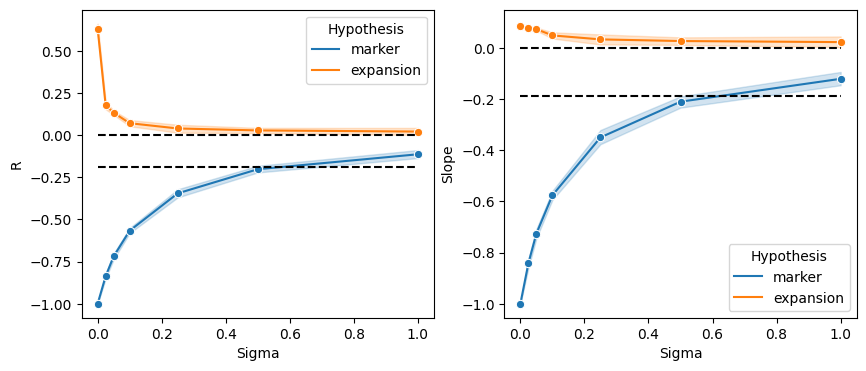

In [78]:
pcc = []
for k in np.arange(mc_runs):
    df_res_k = df_res[df_res.MC==k]
    for h in ['marker','expansion']:
        df_res_k_h = df_res_k[df_res_k.Hypothesis==h]
        for sigma in sigma_array:
            slope, intercept, r, p, se = linregress(df_res_k_h[df_res_k_h.Sigma==sigma].X, df_res_k_h[df_res_k_h.Sigma==sigma].Y)
            pcc.append([k, h, sigma, slope, r, p])
df_pcc = pd.DataFrame(pcc, columns=['MCrun','Hypothesis','Sigma','Slope','R','P'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
_ = sns.lineplot(x="Sigma", y="R", hue='Hypothesis', data=df_pcc, ax=ax[0], marker='o')
_ = ax[0].plot([0,1],[0,0],'k--')
_ = ax[0].plot([0,1],[-0.19,-0.19],'k--')
_ = sns.lineplot(x="Sigma", y="Slope", hue='Hypothesis', data=df_pcc, ax=ax[1], marker='o')
_ = ax[1].plot([0,1],[0,0],'k--')
_ = ax[1].plot([0,1],[-0.19,-0.19],'k--')

In [72]:
df_res_k_h[df_res_k_h.Sigma==sigma]

,Sigma,MC,Individual,X,Y,Hypothesis
1400,0.0,1,0,-3.0,8.0,marker
1402,0.0,1,0,-3.0,8.0,marker
1404,0.0,1,0,-3.0,8.0,marker
1406,0.0,1,0,-3.0,8.0,marker
1408,0.0,1,0,-3.0,8.0,marker
...,...,...,...,...,...,...
1590,0.0,1,19,-3.0,8.0,marker
1592,0.0,1,19,-3.0,8.0,marker
1594,0.0,1,19,-3.0,8.0,marker
1596,0.0,1,19,-3.0,8.0,marker


In [68]:
df_res_k_h

,Sigma,MC,Individual,X,Y,Hypothesis
4192,0.0,3,0,-3.000000,8.000000,marker
4194,0.0,3,0,-3.000000,8.000000,marker
4196,0.0,3,0,-3.000000,8.000000,marker
4198,0.0,3,0,-3.000000,8.000000,marker
4200,0.0,3,0,-3.000000,8.000000,marker
...,...,...,...,...,...,...
5582,1.0,3,19,-2.132732,8.124210,marker
5584,1.0,3,19,-1.841102,10.618993,marker
5586,1.0,3,19,-1.192655,9.544991,marker
5588,1.0,3,19,-0.273445,9.942185,marker


In [225]:
_ = plt.scatter(df_res[df_res.Sigma==0.2,].X, df_res[df_res.Sigma==0.2,].Y)

InvalidIndexError: (0          False
1          False
2          False
3          False
4          False
           ...  
5249666    False
5249667    False
5249668    False
5249669    False
5249670    False
Name: Sigma, Length: 5249671, dtype: bool,)

In [221]:
sigma_array

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [223]:
set(df_res.Sigma)

{0.0,
 0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.8500000000000001,
 0.9,
 0.9500000000000001,
 1.0}